# Assignment 1 - Propagation Settings

In [1]:
''' 
Copyright (c) 2010-2020, Delft University of Technology
All rigths reserved

This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.
'''

import numpy as np
from tudatpy import elements
from tudatpy.io import save2txt
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice_interface
from tudatpy.kernel.simulation import environment_setup
from tudatpy.kernel.simulation import propagation_setup
from matplotlib import pyplot as plt

In [2]:
# student number: 1244779 --> 1244ABC
A = 7
B = 2
C = 6

simulation_start_epoch = 33.15 * constants.JULIAN_YEAR + A * 7.0 * constants.JULIAN_DAY + \
                            B * constants.JULIAN_DAY + C * constants.JULIAN_DAY / 24.0
simulation_end_epoch = simulation_start_epoch + 344.0 * constants.JULIAN_DAY / 24.0

## Create Environment and Vehicle

In [3]:
###########################################################################
# CREATE ENVIRONMENT ######################################################
###########################################################################

# Load spice kernels.
spice_interface.load_standard_kernels()

# Create body objects.
bodies_to_create = ["Ganymede", "Jupiter"]
global_frame_origin = "SSB"
global_frame_orientation = "ECLIPJ2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)    

# Add Ganymede exponential atmosphere 
density_scale_height = 40.0E3
density_at_zero_altitude = 2.0E-9
body_settings.get( "Ganymede" ).atmosphere_settings = environment_setup.atmosphere.exponential( 
        density_scale_height, density_at_zero_altitude)

bodies = environment_setup.create_system_of_bodies(body_settings)

###########################################################################
# CREATE VEHICLE ##########################################################
###########################################################################

# Create vehicle object
bodies.create_empty_body( "JUICE" )

# Set mass of vehicle
bodies.get_body( "JUICE" ).set_constant_mass(2000.0)

# Create aerodynamic coefficients interface
reference_area = 100.0
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
        reference_area,[drag_coefficient,0,0] )
environment_setup.add_aerodynamic_coefficient_interface(
        bodies, "JUICE", aero_coefficient_settings );

## Propagate Dynamics for various cases

In [4]:
cases = ['unperturbed', 'case_i', 'case_ii']

"""
unperturbed: Ganymede PM

case_i: Ganymede PM, Jupiter SH D/O 4/0

case_ii: Ganymede PM, Ganymede aerodynamic
"""

simulation_results_dict = dict()
dependent_variables_dict = dict()
for case in cases:    
    ###########################################################################
    # CREATE ACCELERATIONS ####################################################
    ###########################################################################

    # Define bodies that are propagated.
    bodies_to_propagate = ["JUICE"]

    # Define central bodies.
    central_bodies = ["Ganymede"]

    # Define accelerations acting on vehicle.
    if case == 'unperturbed':
        acceleration_settings_on_vehicle = dict(
            Ganymede = 
            [
                propagation_setup.acceleration.point_mass_gravity()
            ]
        )
    if case == 'case_i':
        acceleration_settings_on_vehicle = dict(
            Ganymede = 
            [
                propagation_setup.acceleration.point_mass_gravity()
            ],
            Jupiter = 
            [
                propagation_setup.acceleration.spherical_harmonic_gravity(4, 0)
            ]
        )
    if case == 'case_ii':
        acceleration_settings_on_vehicle = dict(
            Ganymede = 
            [   
                propagation_setup.acceleration.point_mass_gravity(),
                propagation_setup.acceleration.aerodynamic()
            ]
        )

    # Create global accelerations dictionary.
    acceleration_settings = {"JUICE": acceleration_settings_on_vehicle}

    # Create acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
            bodies, acceleration_settings, bodies_to_propagate, central_bodies)


    ###########################################################################
    # CREATE PROPAGATION SETTINGS #############################################
    ###########################################################################

    # Define initial state.
    system_initial_state = spice_interface.get_body_cartesian_state_at_epoch(
       target_body_name="JUICE",
       observer_body_name="Ganymede",
       reference_frame_name="ECLIPJ2000",
       aberration_corrections="NONE",
       ephemeris_time= simulation_start_epoch )

    # Save magnitude of perturbations for both cases
    if case == 'unperturbed':
        dependent_variables_to_save = [ ]
    if case == 'case_i':
        dependent_variables_to_save = [ 
            propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "JUICE", "Jupiter" )
        ]
    if case == 'case_ii':
        dependent_variables_to_save = [ 
            propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.aerodynamic_type, "JUICE", "Ganymede" )
        ]

    # Create propagation settings.
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        system_initial_state,
        simulation_end_epoch,
        output_variables = dependent_variables_to_save
    )

    # Create numerical integrator settings.
    fixed_step_size = 10.0
    integrator_settings = propagation_setup.integrator.runge_kutta_4(
        simulation_start_epoch,
        fixed_step_size
    )

    ###########################################################################
    # PROPAGATE ORBIT #########################################################
    ###########################################################################

    # Create simulation object and propagate dynamics.
    dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
        bodies, integrator_settings, propagator_settings)
    
    simulation_results_dict[case] = dynamics_simulator.state_history
    dependent_variables_dict[case] = dynamics_simulator.dependent_variable_history

    ###########################################################################
    # PRINT FINAL PROPAGATION TIME AND STATE ##################################
    ###########################################################################

    final_time_step=list(simulation_results_dict[case].keys())[-1]
    first_time_step=list(simulation_results_dict[case].keys())[0]

    print(
        f"""
    JUICE Propagation Results of {case}.

    Final propagation time of JUICE [s]: {simulation_end_epoch}
    Final Cartesian state of JUICE is [m]: \n{
        simulation_results_dict[case][final_time_step][:]}

        """
    )

    ###########################################################################
    # SAVE RESULTS ############################################################
    ###########################################################################
    
#     save2txt(solution=simulation_result,
#              filename="JUICEPropagationHistory_Q4_" + case + ".dat",
#              directory="./",  # default = "./" 
#              column_names=None,  # default = None 
#              )
    
    

for case_idx, case in enumerate(cases):  
    if case_idx != 0:
        lines = ['\n']*11 #There are a total of eleven lines that need to be written

        q_n = 4

        with open('cartesian_results_AE4868_2020_A1_5382726.txt','r') as f:
            file_lines = f.readlines()

        for i, file_line in enumerate(file_lines):
            lines[i] = file_line

        line = f'{simulation_end_epoch}'
        for item in simulation_results_dict[case][final_time_step][:]:
            line = ' '.join((line,str(item)))
        line += '\n'

        lines[q_n+case_idx-2] = line
        with open('cartesian_results_AE4868_2020_A1_5382726.txt','w') as f:
            f.writelines(lines)


    JUICE Propagation Results of unperturbed.

    Final propagation time of JUICE [s]: 1051800840.0
    Final Cartesian state of JUICE is [m]: 
[-1.61771321e+06 -3.90797315e+05  2.62530099e+06  1.27913692e+03
  8.62539747e+02  9.07363336e+02]

        

    JUICE Propagation Results of case_i.

    Final propagation time of JUICE [s]: 1051800840.0
    Final Cartesian state of JUICE is [m]: 
[-2.19371105e+06 -8.97330631e+05  2.00065680e+06  9.07598719e+02
  7.81910746e+02  1.33542187e+03]

        

    JUICE Propagation Results of case_ii.

    Final propagation time of JUICE [s]: 1051800840.0
    Final Cartesian state of JUICE is [m]: 
[-1.61637475e+06 -3.89895494e+05  2.62624664e+06  1.27969349e+03
  8.62674244e+02  9.06460365e+02]

        


## Pre-process Results

In [5]:
simulation_result_unperturbed = simulation_results_dict[ 'unperturbed']
time = np.vstack(simulation_result_unperturbed.keys())
time = time.reshape(time.shape[0])
r_unperturbed = np.vstack(list(simulation_result_unperturbed.values()))[:,0:3]
simulation_result_i = simulation_results_dict[ 'case_i' ]
r_case_i = np.vstack(list(simulation_result_i.values()))[:,0:3]
time_i = np.vstack(simulation_result_i.keys())
time_i = time_i.reshape(time_i.shape[0])
simulation_result_ii = simulation_results_dict[ 'case_ii' ]
r_case_ii = np.vstack(list(simulation_result_ii.values()))[:,0:3]
time_ii = np.vstack(simulation_result_ii.keys())
time_ii = time_ii.reshape(time_ii.shape[0])

dependent_variables_unperturbed = dependent_variables_dict[ 'unperturbed' ]
dependent_variables_i = dependent_variables_dict[ 'case_i' ]
a_case_i = np.vstack(list(dependent_variables_i.values()))[:,0]
dependent_variables_ii = dependent_variables_dict[ 'case_ii' ]
a_case_ii = np.vstack(list(dependent_variables_ii.values()))[:,0]

difference_in_cartesian_position_i  = np.linalg.norm(r_case_i  - r_unperturbed,axis=1)
difference_in_cartesian_position_ii = np.linalg.norm(r_case_ii - r_unperturbed,axis=1)

efficiency_i = [difference_in_cartesian_position_i[i]/np.trapz(a_case_i[:i],time_i[:i]) for i in range(len(time_i))]
efficiency_ii = [difference_in_cartesian_position_ii[i]/np.trapz(a_case_ii[:i],time_ii[:i]) for i in range(len(time_ii))]

<ipython-input-5-a7e7630acb8c>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  time = np.vstack(simulation_result_unperturbed.keys())
<ipython-input-5-a7e7630acb8c>:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  time_i = np.vstack(simulation_result_i.keys())
<ipython-input-5-a7e7630acb8c>:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  time_ii = np.vstack(simulation_result_ii.keys())
<ipython-input-5-a7e7630acb8c>:23: RuntimeWarning: invalid value encountered in double_scalars
  e

## Plot Results

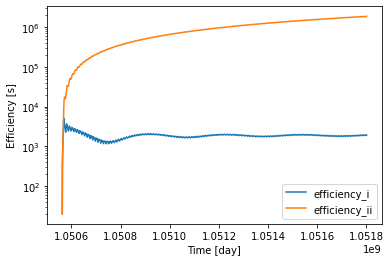

In [6]:
plt.plot(time_i,  efficiency_i, label = 'efficiency_i')
plt.plot(time_ii, efficiency_ii, label = 'efficiency_ii')
plt.semilogy()
plt.xlabel('Time [day]')
plt.ylabel('Efficiency [s]')
plt.legend()
plt.savefig( fname = 'figures/efficienciQ4.png')
plt.show()